<img style="width:100%" src="title.png" />

### Category:

- <a href="#Description">Description</a>
- <a href="#Data Exploration">Data Exploration</a>
- <a href='#Data Reduction'>Data Reduction</a>
- <a href='#Feature Engineering'>Feature Engineering</a>
- <a href='#Encoding'>Encoding</a>
- <a href='#Implementing Algorithms'>Implementing Algorithms</a>

### Description <a name='Description' />
The competition is to predict repeat buyers (those who redeem a coupon and purchase that product afterwards). For this we have the labelled data (did become repeat buyer, did not become repeat buyer) for about 160,000 shoppers (the trainHistory set).

Our task is to predict the labels for about 150,000 other shoppers (the testHisotory set). For this we can use a file called transactions.csv. It’s a huge file (unzipped about 22GB) containing nearly 350 million rows. The total amount spend in the transaction data is nearing 1.5 billion.

### Data Exploration <a name='Data Exploration' />

We use a sample dataset with only a few shoppers to explore the transaction data.

In [356]:
import numpy as np 
import pandas as pd
from datetime import datetime

In [359]:
sample = pd.read_csv('sample.csv')

In [360]:
sample.head()

,id,chain,dept,category,company,brand,date,productsize,productmeasure,purchasequantity,purchaseamount
0,86246,205,7,707,1078778070,12564,2012-03-02,12.0,OZ,1,7.59
1,86246,205,63,6319,107654575,17876,2012-03-02,64.0,OZ,1,1.59
2,86246,205,97,9753,1022027929,0,2012-03-02,1.0,CT,1,5.99
3,86246,205,25,2509,107996777,31373,2012-03-02,16.0,OZ,1,1.99
4,86246,205,55,5555,107684070,32094,2012-03-02,16.0,OZ,2,10.38


### Data Reduction <a name='Data Reduction' />

- Chosing transactions from only **chain=4**. Output into a new file "reduced2.csv"
- Keeping data only from 1 year from "reduced2.csv". Output into a new file "data_s.csv"
- Using only customers in trainHistory which have at least one transaction in the reduced transaction dataset
- Inner join train_reduced & "offers.csv" on offer. Output into a new file "combine.csv"

In [41]:
loc_transactions = "transactions.csv"
loc_reduced = "reduced2.csv"  #Output file 
def reduce_data(loc_transactions, loc_reduced):
    with open(loc_reduced, "wb") as outfile:
        for e, line in enumerate( open(loc_transactions) ):
            if line.split(",")[1] in ['4']:  # If you want larger data, use ['2,'4','8'] instead of ['4'].
                outfile.write( line )

reduce_data(loc_transactions, loc_reduced)
#reduced2.csv contains transactions from chain_id = 4 (Only one chain).
#redcued2.csv is your new transactions data. Use customers in this transaction data to build a model.

In [96]:
import pandas as pd
data=pd.read_csv("reduced2.csv",header=None,names=["id","chain","dept",'category','company','brand','date','productsize','productmeasure','productquantity','productamount'])

In [364]:
print data.chain.unique()

[4]


In [376]:
##########################################

In [362]:
#Keeping data only from 1 year from "reduced2.csv"
drops=[]
for i in range(len(data.id)):
    dates=data.date[i].strip().split('-')
    if (dates[0]=='2012' and int(dates[1])>=5) or (dates[0]=='2013' and int(dates[1])<5):
        a=1
    else:
        drops.append(data.index[i])
        
data_s=data.drop(drops)
data_s.reset_index(inplace=True,drop=True)

In [99]:
data_s.to_csv('data_s.csv',index=False)

In [365]:
data_s.head()

,id,chain,dept,category,company,brand,date,productsize,productmeasure,productquantity,productamount
0,12524696,4,58,5825,102113020,15704,2012-05-03,14.00,OZ,2,5.70
1,12524696,4,9,907,102113020,15704,2012-05-03,16.00,OZ,1,1.69
2,12524696,4,4,419,1074759979,7168,2012-05-03,3.17,OZ,1,1.70
3,12524696,4,55,5567,107064070,19704,2012-05-07,21.00,OZ,2,7.00
4,12524696,4,55,5567,107064070,19704,2012-05-07,24.00,OZ,1,3.50


In [378]:
##########################################

In [371]:
train = pd.read_csv('trainHistory.csv')
test = pd.read_csv('testHistory.csv')
offer = pd.read_csv('offers.csv')
data_s = pd.read_csv('data_s.csv')

In [373]:
#Inner join data_s and combine on id
cust_s_train = pd.merge(data_s,train,on=['id'])
cust_s_train.shape

(1352131, 17)

In [374]:
unique = cust_s_train.id.unique()
len(unique)

1753

In [375]:
#Use only customers which have at least one transaction in the reduced transaction dataset
train_reduced = train[train['id'].isin(unique)]
train_reduced.shape

(1753, 7)

In [10]:
##########################################

In [16]:
#Combine train_reduced & offers.csv on offer
combine = pd.merge(train_reduced,offer,on=['offer'])
combine.head()

,id,chain,offer,market,repeattrips,repeater,offerdate,category,quantity,company,offervalue,brand
0,13807224,4,1204576,1,0,f,2013-04-05,5616,1,104610040,1.0,15889
1,16138642,4,1204576,1,0,f,2013-04-05,5616,1,104610040,1.0,15889
2,17888308,4,1204576,1,0,f,2013-04-05,5616,1,104610040,1.0,15889
3,18277411,4,1204576,1,0,f,2013-04-04,5616,1,104610040,1.0,15889
4,68451850,4,1204576,1,0,f,2013-04-07,5616,1,104610040,1.0,15889


In [95]:
combine.to_csv('combine.csv',index=False)

### Feature Engineering <a name="Feature Engineering" />

**A large part of this competition is feature engineering: Creating good indicative features from the purchase history.**

We will generate the following features:

**total_spend**: the total amount spend by the shopper in the reduced dataset  
**total_quant**: the total quantity (number of units) spend by the shopper in the reduced dataset

**has_bought_company**: the number of times a shopper has bought from the company on offer    
**has_bought_company_a**: the total amount the shopper has bought from the company on offer  
**has_bought_company_q**: the quantity of items bought from the company on offer   
**has_bought_company_30**: the number of times a shopper has bought from the company on offer in the 30 days before the date the coupon was offered  
**has_bought_company_60**: the number of times a shopper has bought from the company on offer in the 60 days before the date the coupon was offered  
......   
**has_bought_company_180**: 180 days before  


These same features for:

**has_bought_category**: the number of times a shopper has bought from the category on offer      
**has_bought_brand**: the number of times a shopper has bought from the brand on offer    

And:

**never_bought_company**: a negative feature for when the shopper has never bought from the company on offer before   
**never_bought_category**: a negative feature for when the shopper has never bought from the category on offer before  
**never_bought_brand**: a negative feature for when the shopper has never bought from the brand on offer before  
**has_bought_company_brand_category**: if this feature is present the shopper has bought from the company, brand, and category on offer      
**has_bought_brand_category**: if this feature is present the shopper has bought from the brand and category on offer      
**has_bought_brand_company**: if this feature is present the shopper has bought from the brand and company on offer  


In [379]:
#Feature Extraction
def diff_days(s1,s2):
    date_format = "%Y-%m-%d"
    a = datetime.strptime(s1, date_format)
    b = datetime.strptime(s2, date_format)
    delta = b - a
    return delta.days


def extract_features(cust_id):
    df = combine.loc[combine.id == cust_id,:]
    df = df.reset_index(drop=True)
    
    offer_category = df.category.values[0]
    offer_company = df.company.values[0]
    offer_brand = df.brand.values[0]
    
    data_id = data_s.loc[data_s.id == cust_id,:]
    data_id = data_id.reset_index(drop=True)
    
    
    #generate features from transaction record
    df['total_spend'] = data_id.productamount.sum()
    df['total_quant'] = data_id.productquantity.sum()

    df['has_bought_company'] = 0
    df['has_bought_company_q'] = 0
    df['has_bought_company_a'] = 0
    df['has_bought_company_30'] = 0
    df['has_bought_company_q_30'] = 0
    df['has_bought_company_a_30'] = 0
    df['has_bought_company_60'] = 0
    df['has_bought_company_q_60'] = 0
    df['has_bought_company_a_60'] = 0
    df['has_bought_company_90'] = 0
    df['has_bought_company_q_90'] = 0
    df['has_bought_company_a_90'] = 0
    df['has_bought_company_180'] = 0
    df['has_bought_company_q_180'] = 0
    df['has_bought_company_a_180'] = 0
    
    df['has_bought_category'] = 0
    df['has_bought_category_q'] = 0
    df['has_bought_category_a'] = 0
    df['has_bought_category_30'] = 0
    df['has_bought_category_q_30'] = 0
    df['has_bought_category_a_30'] = 0
    df['has_bought_category_60'] = 0
    df['has_bought_category_q_60'] = 0
    df['has_bought_category_a_60'] = 0
    df['has_bought_category_90'] = 0
    df['has_bought_category_q_90'] = 0
    df['has_bought_category_a_90'] = 0
    df['has_bought_category_180'] = 0
    df['has_bought_category_q_180'] = 0
    df['has_bought_category_a_180'] = 0
    
    df['has_bought_brand'] = 0
    df['has_bought_brand_q'] = 0
    df['has_bought_brand_a'] = 0
    df['has_bought_brand_30'] = 0
    df['has_bought_brand_q_30'] = 0
    df['has_bought_brand_a_30'] = 0
    df['has_bought_brand_60'] = 0
    df['has_bought_brand_q_60'] = 0
    df['has_bought_brand_a_60'] = 0
    df['has_bought_brand_90'] = 0
    df['has_bought_brand_q_90'] = 0
    df['has_bought_brand_a_90'] = 0
    df['has_bought_brand_180'] = 0
    df['has_bought_brand_q_180'] = 0
    df['has_bought_brand_a_180'] = 0
    
    for i in range(len(data_id)):
        if data_id.loc[i].company == offer_company:
            df['has_bought_company'] += 1.0
            df['has_bought_company_q'] += float( data_id.loc[i].productquantity )
            df['has_bought_company_a'] += float( data_id.loc[i].productamount )

            date_diff_days = diff_days(data_id.loc[i].date,df.loc[0].offerdate)
            if date_diff_days < 30:
                df['has_bought_company_30'] += 1.0
                df['has_bought_company_q_30'] += float( data_id.loc[i].productquantity )
                df['has_bought_company_a_30'] += float( data_id.loc[i].productamount )
                        
            if date_diff_days < 60:
                df['has_bought_company_60'] += 1.0
                df['has_bought_company_q_60'] += float( data_id.loc[i].productquantity )
                df['has_bought_company_a_60'] += float( data_id.loc[i].productamount )
                        
            if date_diff_days < 90:
                df['has_bought_company_90'] += 1.0
                df['has_bought_company_q_90'] += float( data_id.loc[i].productquantity )
                df['has_bought_company_a_90'] += float( data_id.loc[i].productamount )
                        
            if date_diff_days < 180:
                df['has_bought_company_180'] += 1.0
                df['has_bought_company_q_180'] += float( data_id.loc[i].productquantity )
                df['has_bought_company_a_180'] += float( data_id.loc[i].productamount )

                    
        if data_id.loc[i].category == offer_category:
            df['has_bought_category'] += 1.0
            df['has_bought_category_q'] += float( data_id.loc[i].productquantity )
            df['has_bought_category_a'] += float( data_id.loc[i].productamount )

            date_diff_days = diff_days(data_id.loc[i].date,df.loc[0].offerdate)
            if date_diff_days < 30:
                df['has_bought_category_30'] += 1.0
                df['has_bought_category_q_30'] += float( data_id.loc[i].productquantity )
                df['has_bought_category_a_30'] += float( data_id.loc[i].productamount )
                        
            if date_diff_days < 60:
                df['has_bought_category_60'] += 1.0
                df['has_bought_category_q_60'] += float( data_id.loc[i].productquantity )
                df['has_bought_category_a_60'] += float( data_id.loc[i].productamount )
                        
            if date_diff_days < 90:
                df['has_bought_category_90'] += 1.0
                df['has_bought_category_q_90'] += float( data_id.loc[i].productquantity )
                df['has_bought_category_a_90'] += float( data_id.loc[i].productamount )
                        
            if date_diff_days < 180:
                df['has_bought_category_180'] += 1.0
                df['has_bought_category_q_180'] += float( data_id.loc[i].productquantity )
                df['has_bought_category_a_180'] += float( data_id.loc[i].productamount )
                   
        if data_id.loc[i].brand == offer_brand:
            df['has_bought_brand'] += 1.0
            df['has_bought_brand_q'] += float( data_id.loc[i].productquantity )
            df['has_bought_brand_a'] += float( data_id.loc[i].productamount )

            date_diff_days = diff_days(data_id.loc[i].date,df.loc[0].offerdate)
            if date_diff_days < 30:
                df['has_bought_brand_30'] += 1.0
                df['has_bought_brand_q_30'] += float( data_id.loc[i].productquantity )
                df['has_bought_brand_a_30'] += float( data_id.loc[i].productamount )
                        
            if date_diff_days < 60:
                df['has_bought_brand_60'] += 1.0
                df['has_bought_brand_q_60'] += float( data_id.loc[i].productquantity )
                df['has_bought_brand_a_60'] += float( data_id.loc[i].productamount )
                        
            if date_diff_days < 90:
                df['has_bought_brand_90'] += 1.0
                df['has_bought_brand_q_90'] += float( data_id.loc[i].productquantity )
                df['has_bought_brand_a_90'] += float( data_id.loc[i].productamount )
                        
            if date_diff_days < 180:
                df['has_bought_brand_180'] += 1.0
                df['has_bought_brand_q_180'] += float( data_id.loc[i].productquantity )
                df['has_bought_brand_a_180'] += float( data_id.loc[i].productamount )
                
                #last_id = row[0]
                #if e % 100000 == 0:
                    #print e
    
    return df

In [380]:
#Take 15 minutes to run this code
#Create X_features
X_features = pd.DataFrame()
start_time = datetime.now()
for e,cust_id in enumerate(combine.id.values):
    X_features = pd.concat([X_features,extract_features(cust_id)])
    if e%500 == 0:
        print e,datetime.now()-start_time

0 0:00:00.868946
500 0:04:31.904887
1000 0:08:35.793913
1500 0:12:53.946410


In [384]:
X_features['never_bought_company'] = 0
X_features['never_bought_category'] = 0
X_features['never_bought_brand'] = 0
X_features['has_bought_brand_company_category'] = 0
X_features['has_bought_brand_category'] = 0
X_features['has_bought_brand_company'] = 0

X_features = X_features.reset_index(drop=True)

In [385]:
for i in range(len(X_features)):
    #generate negative features
    if X_features.loc[i].has_bought_company == 0:
        X_features.set_value(i,'never_bought_company',1)

    if X_features.loc[i].has_bought_category == 0:
        X_features.set_value(i,'never_bought_category',1)
        
    if X_features.loc[i].has_bought_brand == 0:
        X_features.set_value(i,'never_bought_brand',1)

    if X_features.loc[i].has_bought_company != 0 and X_features.loc[i].has_bought_category != 0 and X_features.loc[i].has_bought_brand != 0:
        X_features.set_value(i,'has_bought_brand_company_category',1) 

    if X_features.loc[i].has_bought_category != 0 and X_features.loc[i].has_bought_brand != 0:
        X_features.set_value(i,'has_bought_brand_category',1)

    if X_features.loc[i].has_bought_company != 0 and X_features.loc[i].has_bought_brand != 0:
         X_features.set_value(i,'has_bought_brand_company',1)


In [387]:
X_features.to_csv('X_features.csv',index=False)

In [388]:
X_features.shape

(1753, 65)

In [389]:
X_features.head()

,id,chain,offer,market,repeattrips,repeater,offerdate,category,quantity,company,...,has_bought_brand_a_90,has_bought_brand_180,has_bought_brand_q_180,has_bought_brand_a_180,never_bought_company,never_bought_category,never_bought_brand,has_bought_brand_company_category,has_bought_brand_category,has_bought_brand_company
0,13807224,4,1204576,1,0,f,2013-04-05,5616,1,104610040,...,0.00,1.0,1.0,4.49,0,0,0,1,1,1
1,16138642,4,1204576,1,0,f,2013-04-05,5616,1,104610040,...,3.99,2.0,2.0,8.98,0,1,0,0,0,1
2,17888308,4,1204576,1,0,f,2013-04-05,5616,1,104610040,...,0.00,0.0,0.0,0.00,1,0,1,0,0,0
3,18277411,4,1204576,1,0,f,2013-04-04,5616,1,104610040,...,0.00,4.0,5.0,21.45,0,0,0,1,1,1
4,68451850,4,1204576,1,0,f,2013-04-07,5616,1,104610040,...,0.00,1.0,1.0,3.99,0,1,0,0,0,1


In [390]:
#Check missing values
check = X_features.apply(lambda x: sum(x.isnull()),axis=0)

check.value_counts()

0    65
dtype: int64

### Encoding <a name='Encoding' />

Encoding the values to category, company, and brand.

In [350]:
X_features = pd.read_csv('X_features.csv')

In [391]:
#Encoding the values
category_uni = X_features.category.unique()
for category_val in category_uni:
    X_features['category_'+str(category_val)] = 1*(X_features['category'] == category_val)

company_uni = X_features.company.unique()
for company_val in company_uni:
    X_features['company_'+str(company_val)] = 1*(X_features['company'] == company_val)

brand_uni = X_features.brand.unique()
for brand_val in brand_uni:
    X_features['brand_'+str(brand_val)] = 1*(X_features['brand'] == brand_val)


In [392]:
X_features.head()

,id,chain,offer,market,repeattrips,repeater,offerdate,category,quantity,company,...,company_106414464,company_104460040,company_103320030,company_107717272,brand_15889,brand_13474,brand_3718,brand_875,brand_102504,brand_7668
0,13807224,4,1204576,1,0,f,2013-04-05,5616,1,104610040,...,0,0,0,0,1,0,0,0,0,0
1,16138642,4,1204576,1,0,f,2013-04-05,5616,1,104610040,...,0,0,0,0,1,0,0,0,0,0
2,17888308,4,1204576,1,0,f,2013-04-05,5616,1,104610040,...,0,0,0,0,1,0,0,0,0,0
3,18277411,4,1204576,1,0,f,2013-04-04,5616,1,104610040,...,0,0,0,0,1,0,0,0,0,0
4,68451850,4,1204576,1,0,f,2013-04-07,5616,1,104610040,...,0,0,0,0,1,0,0,0,0,0


In [393]:
X_features.shape

(1753, 82)

### Implementing Algorithms <a name='Implementing Algorithms' />

- Let Y_features equals 'repater'
- Drop unnecessary features in X_features ('id','chain','offer','category','company','brand','repeater','repeattrips','offerdate')
- Split the data into training and test sets
- Implement logistic regression with different regularization parameters and check AUC score
- Implement Random Forest with 200 estimators and check AUC score
- Implement XGBoost and Tune The Number of Trees and Max Depth in XGBoost. Then check AUC score

**Conclusion**: Highest AUC score is for XGBoost algorithm with max_depth=6 and n_estimators=4, which is 59.911%.

In [395]:
#Predction using Scikit learn
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn import metrics
#from sklearn.feature_selection import f_classif, SelectKBest
#from sklearn.pipeline import Pipeline

In [396]:
Y_features = X_features[['id','repeater']]
Y_features['repeater'] = 1 * (Y_features['repeater'] == 't')
X_features.drop(['id','chain','offer','category','company','brand','repeater','repeattrips','offerdate'],axis=1,inplace=True)

/Users/Frank/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [397]:
# Split the data into training and test sets
X_train,X_test,Y_train,Y_test=train_test_split(X_features,Y_features.repeater,test_size=0.5,random_state=3)

In [398]:
###### Logistic Regression ######
## regularization parameter
C = [0.03,0.09,0.27,0.81,1.0,3.0,9.0,27.0,81.0,243.0]

for i in C:
    model = LogisticRegression(C=i) # Create a logistic regression class object
    model.fit(X_train,Y_train) # Train the model
    Y_pred = model.predict(X_test) # Prediction from X_test
    prob = model.predict_proba(X_test)
    score = roc_auc_score(Y_test,prob[:,1])
    print 'AUC score for C={0:.3f} is: {1:.3%}'.format(i,score)

AUC score for C=0.030 is: 56.928%
AUC score for C=0.090 is: 55.318%
AUC score for C=0.270 is: 54.072%
AUC score for C=0.810 is: 53.636%
AUC score for C=1.000 is: 52.887%
AUC score for C=3.000 is: 50.263%
AUC score for C=9.000 is: 50.512%
AUC score for C=27.000 is: 50.546%
AUC score for C=81.000 is: 51.793%
AUC score for C=243.000 is: 49.861%


In [399]:
###### Random Forest ######
rf = RandomForestClassifier(n_estimators=200)

rf.fit(X_train,Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [400]:
#AUC score
score = roc_auc_score(Y_test, rf.predict_proba(X_test)[:,1])

print 'AUC score is: {0:.3%}'.format(score)

AUC score is: 53.665%


In [401]:
#Probability that a customer repeat-purchased
prob = rf.predict_proba(X_test)[:,1]

prob[:10]

array([ 0.23 ,  0.29 ,  0.29 ,  0.28 ,  0.   ,  0.035,  0.275,  0.25 ,
        0.405,  0.17 ])

In [402]:
###### XGBoost ######
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score


In [403]:
params = {
    'objective': 'binary:logistic',
    'max_depth': 6,
    'learning_rate': 1.0,
    'silent': 1.0,
    'n_estimators': 4
}

In [404]:
bst = XGBClassifier(**params).fit(X_train, Y_train)

In [405]:
prob = bst.predict_proba(X_test)[:,1]

score = roc_auc_score(Y_test,prob)

print 'AUC score is: {0:.3%}'.format(score)

AUC score is: 59.911%


In [406]:
#Predicted Correctly
preds = bst.predict(X_test)
preds

correct = 0
for i in range(len(preds)):
    if (Y_test.iloc[i] == preds[i]):
        correct += 1
        
acc = accuracy_score(Y_test, preds)

print('Predicted correctly: {0}/{1}'.format(correct, len(preds)))
print('Error: {0:.4f}'.format(1-acc))


Predicted correctly: 641/877
Error: 0.2691


In [342]:
##########################################

[2, 4, 6, 8]
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best: 0.581058 using {'n_estimators': 6, 'max_depth': 8}
0.541174 (0.048976) with: {'n_estimators': 4, 'max_depth': 2}
0.552827 (0.064418) with: {'n_estimators': 5, 'max_depth': 2}
0.558397 (0.066919) with: {'n_estimators': 6, 'max_depth': 2}
0.561882 (0.065654) with: {'n_estimators': 7, 'max_depth': 2}
0.573469 (0.063685) with: {'n_estimators': 8, 'max_depth': 2}
0.565818 (0.058823) with: {'n_estimators': 4, 'max_depth': 4}
0.568423 (0.060861) with: {'n_estimators': 5, 'max_depth': 4}
0.566617 (0.071137) with: {'n_estimators': 6, 'max_depth': 4}
0.569136 (0.059158) with: {'n_estimators': 7, 'max_depth': 4}
0.574080 (0.061980) with: {'n_estimators': 8, 'max_depth': 4}
0.579962 (0.060417) with: {'n_estimators': 4, 'max_depth': 6}
0.572971 (0.060699) with: {'n_estimators': 5, 'max_depth': 6}
0.571932 (0.055586) with: {'n_estimators': 6, 'max_depth': 6}
0.572931 (0.046067) with: {'n_estimators': 7, 'max_depth': 6}

[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    2.4s finished


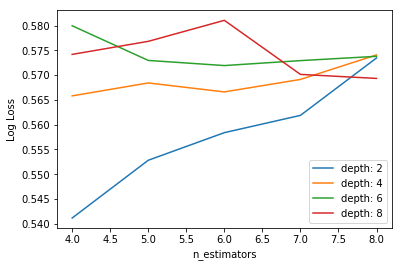

In [407]:
#Tune The Number of Trees and Max Depth in XGBoost (cross-validation)
from pandas import read_csv
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import matplotlib
%matplotlib inline
from matplotlib import pyplot
import numpy


# grid search
model = XGBClassifier()
n_estimators = [4, 5, 6, 7, 8]
max_depth = [2, 4, 6, 8]
print(max_depth)
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="roc_auc", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(X_test, Y_test)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
# plot results
scores = numpy.array(means).reshape(len(max_depth), len(n_estimators))
for i, value in enumerate(max_depth):
    pyplot.plot(n_estimators, scores[i], label='depth: ' + str(value))
pyplot.legend()
pyplot.xlabel('n_estimators')
pyplot.ylabel('Log Loss')
